<a href="https://colab.research.google.com/github/OrJaku/road-sign-recognition/blob/master/road_sign_rec_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Biblioteki

In [1]:
import os, shutil, cv2, json
import pandas as pd
import numpy as np
from keras import layers, models, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import time


Using TensorFlow backend.


## Pliki

In [ ]:
cd "/content/drive/My Drive/Colab Notebooks/Road_sign_rec"

/content/drive/My Drive/Colab Notebooks/Road_sign_rec


In [ ]:
cd "/content/drive/My Drive/Colab Notebooks/Road_sign_rec/data"

/content/drive/My Drive/Colab Notebooks/Road_sign_rec/data


In [ ]:
from google.colab import files

uploaded = files.upload()

### Kopiowanie obrazów treningowych na dysk Colab

In [2]:
cd "/content"

/content


In [3]:
try:
  os.mkdir("data")
except FileExistsError:
  pass
!cp "/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/Dataset_extend_zip.zip" "/content/data/Dataset_extend_zip.zip"

In [4]:
cd data

/content/data


In [5]:
!unzip -q Dataset_extend_zip.zip

In [6]:
data_folder = "/content/data/Data"
train_folder = os.path.join(data_folder, 'train_data')
signs_list_train = os.listdir(train_folder)
train_folders_length = {}
for signs_train in signs_list_train:
  train_folders_length[signs_train] = len(os.listdir(os.path.join(train_folder, signs_train)))
print(train_folders_length)

valid_folder = os.path.join(data_folder, 'valid_data')
signs_list_valid = os.listdir(valid_folder)
valid_folders_length = {}
for signs_val in signs_list_valid:
  valid_folders_length[signs_val] = len(os.listdir(os.path.join(valid_folder, signs_val)))
print(valid_folders_length)

{'yield': 1665, 'nosign': 6036, 'limit60': 1144, 'othersign': 786, 'limit50': 1606, 'limit80': 1236, 'stop': 1314, 'limit40': 586, 'cross': 1326, 'limit70': 1264}
{'yield': 832, 'nosign': 2575, 'limit60': 573, 'othersign': 393, 'limit50': 803, 'limit80': 618, 'stop': 506, 'limit40': 294, 'cross': 663, 'limit70': 633}


### Przygotowanie folderów

In [11]:
base_dir = "Data/"
train_dir = os.path.join(base_dir, 'train_data')
try:
  os.mkdir(train_dir)
except FileExistsError:
  pass

cross_train =  os.path.join(train_dir, 'cross')
stop_train =  os.path.join(train_dir, 'stop')
limit50_train =  os.path.join(train_dir, 'limit50')
nosign_train =  os.path.join(train_dir, 'nosign')
try:
  os.mkdir(nosign_train)
except FileExistsError:
  pass
try:
  os.mkdir(cross_train)
except FileExistsError:
  pass
try:
  os.mkdir(stop_train)
except FileExistsError:
  pass
try:
  os.mkdir(limit50_train)
except FileExistsError:
  pass

valid_dir = os.path.join(base_dir, 'valid_data')
try:
  os.mkdir(valid_dir)
except FileExistsError:
  pass

cross_val =  os.path.join(valid_dir, 'cross')
stop_val =  os.path.join(valid_dir, 'stop')
limit50_val =  os.path.join(valid_dir, 'limit50')
nosign_val =  os.path.join(valid_dir, 'nosign')

try:
  os.mkdir(nosign_val)
except FileExistsError:
  pass
try:
  os.mkdir(cross_val)
except FileExistsError:
  pass
try:
  os.mkdir(stop_val)
except FileExistsError:
  pass
try:
  os.mkdir(limit50_val)
except FileExistsError:
  pass

test_dir = os.path.join(base_dir, 'test_data')
try:
  os.mkdir(test_dir)
except FileExistsError:
  pass

cross_test =  os.path.join(test_dir, 'cross')
stop_test =  os.path.join(test_dir, 'stop')
limit50_test =  os.path.join(test_dir, 'limit50')
limit40_test =  os.path.join(test_dir, 'limit40')
limit60_test =  os.path.join(test_dir, 'limit60')
limit70_test =  os.path.join(test_dir, 'limit70')
limit80_test =  os.path.join(test_dir, 'limit80')
limit100_test =  os.path.join(test_dir, 'limit100')
yield_test =  os.path.join(test_dir, 'yield')
nosign_test =  os.path.join(test_dir, 'nosign')
othersign_test =  os.path.join(test_dir, 'othersign')



#### Ilość poszczegónych zdjęć

In [ ]:
cross_origin_path = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/information--pedestrians-crossing--g1/")
stop_origin_path = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/regulatory--stop--g1")
limit50_origin_path = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/regulatory--maximum-speed-limit-50--g1")
nosign_path = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/NoSign")
nosign_path_2 = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/NoSign2")



print('Przejscie dla piszych: ',len(os.listdir(cross_origin_path)))
print('Stop: ', len(os.listdir(stop_origin_path)))
print('Ograniczenie do 50km/h: ', len(os.listdir(limit50_origin_path)))
number_of_nosign = len(os.listdir(nosign_path)) + len(os.listdir(nosign_path_2))
print('Brak znaku', number_of_nosign)


#### Kopowanie i podział zdjęć na treningowe, walidacyjne i testowe

---



In [ ]:

# # train cross
# for image_name in os.listdir(cross_origin_path)[0:1200]:
#   src = os.path.join(cross_origin_path, image_name)
#   dst = os.path.join(cross_train, image_name)
#   shutil.copyfile(src, dst)
# print("train cross copied")

# # validation cross
# for image_name in os.listdir(cross_origin_path)[1200:1800]:
#   src = os.path.join(cross_origin_path, image_name)
#   dst = os.path.join(cross_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation cross copied")

# # test cross
# for image_name in os.listdir(cross_origin_path)[1800:]:
#   src = os.path.join(cross_origin_path, image_name)
#   dst = os.path.join(cross_test, image_name)
#   shutil.copyfile(src, dst)
# print("test cross copied")

# ##################################

# # train stop
# i=0
# for image_name in os.listdir(stop_origin_path)[0:900]:
#   i =+ 1
#   src = os.path.join(stop_origin_path, image_name)
#   dst = os.path.join(stop_train, image_name)
#   shutil.copyfile(src, dst)
#   if i == 200 or i == 400 or i == 700:
#     print(f"Copied {i} ")
# print("train stop copied")


# # validation stop
# for image_name in os.listdir(stop_origin_path)[901:1200]:
#   src = os.path.join(stop_origin_path, image_name)
#   dst = os.path.join(stop_val, image_name)
#   shutil.copyfile(src, dst)
#   if i == 1050:
#     print(f"Copied {i} ")
# print("validation stop copied")

# # test stop
# for image_name in os.listdir(stop_origin_path)[1201:]:
#   src = os.path.join(stop_origin_path, image_name)
#   dst = os.path.join(stop_test, image_name)
#   shutil.copyfile(src, dst)
#   if i == 1300:
#     print(f"Copied {i} ")
# print("test stop copied")


# ##########################

# # train limit50
# for image_name in os.listdir(limit50_origin_path)[0:400]:
#   src = os.path.join(limit50_origin_path, image_name)
#   dst = os.path.join(limit50_train, image_name)
#   shutil.copyfile(src, dst)
# print("train limit50 copied")

# # validation limit50
# for image_name in os.listdir(limit50_origin_path)[400:600]:
#   src = os.path.join(limit50_origin_path, image_name)
#   dst = os.path.join(limit50_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation limit50 copied")

# # test limit50
# for image_name in os.listdir(limit50_origin_path)[600:]:
#   src = os.path.join(limit50_origin_path, image_name)
#   dst = os.path.join(limit50_test, image_name)
#   shutil.copyfile(src, dst)
# print("test limit50 copied")


# #########################


# # train NoSign
# for image_name in os.listdir(nosign_path)[0:1300]:
#   src = os.path.join(nosign_path, image_name)
#   dst = os.path.join(nosign_train, image_name)
#   shutil.copyfile(src, dst)
# print("train NoSign copied")

# # validation NoSign
# for image_name in os.listdir(nosign_path)[1300:1700]:
#   src = os.path.join(nosign_path, image_name)
#   dst = os.path.join(nosign_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation NoSign copied")

# # test NoSign
# for image_name in os.listdir(nosign_path)[1700:]:
#   src = os.path.join(nosign_path, image_name)
#   dst = os.path.join(nosign_test, image_name)
#   shutil.copyfile(src, dst)
# print("test NoSign copied")


# # train NoSign2
# for image_name in os.listdir(nosign_path_2)[0:1300]:
#   src = os.path.join(nosign_path_2, image_name)
#   dst = os.path.join(nosign_train, image_name)
#   shutil.copyfile(src, dst)
# print("train NoSign2 copied")

# # validation NoSign2
# for image_name in os.listdir(nosign_path_2)[1300:1700]:
#   src = os.path.join(nosign_path_2, image_name)
#   dst = os.path.join(nosign_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation NoSign2 copied")

# # test NoSign2
# for image_name in os.listdir(nosign_path_2)[1700:]:
#   src = os.path.join(nosign_path_2, image_name)
#   dst = os.path.join(nosign_test, image_name)
#   shutil.copyfile(src, dst)
# print("test NoSign2 copied")




train cross copied
validation cross copied
test cross copied
train stop copied


#### Przekształcanie plików .jpg na tensory - test

In [ ]:
# datagen = ImageDataGenerator(rotation_range=40,
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
#                              shear_range=0.2,
#                              zoom_range=0.2,
#                              horizontal_flip=True,
#                              fill_mode='nearest') 
                                  

In [ ]:
# from keras.preprocessing import image

# figure = plt.figure()
# fnames = [os.path.join(cross_train, fname) for fname in os.listdir(cross_train)]
# img_path = fnames[3]
# print(img_path)
# img = image.load_img(img_path, target_size=(100, 100))
# plt.imshow(img)
# x = image.img_to_array(img)
# x = x.reshape((1,) + x.shape)
# i=1
# for batch in datagen.flow(x, batch_size=1):
#   plt.subplot(2, 3, i+0)
#   plt
#   plt.imshow(image.array_to_img(batch[0]))
#   i+=1
#   if i%5==0:
#     break

# plt.show()
# figure

In [ ]:
# figure = plt.figure()
# fnames = [os.path.join(cross_train, fname) for fname in os.listdir(cross_train)]
# img_path = fnames[3]
# print(img_path)
# img = image.load_img(img_path, target_size=(100, 100))
# plt.imshow(img)
# figure

##Modele

###Przygotowanie parametrów

####Ustawienia genereatora zdjęć

In [12]:
batch_size = 64
picture_size = 96
class_mode = "categorical"

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False,
                                  vertical_flip=False,                                   
                                  fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (picture_size,picture_size),
    batch_size = batch_size,
    class_mode = class_mode
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (picture_size,picture_size),
    batch_size = batch_size,
    class_mode = class_mode

)
number_of_classes = len(train_generator.class_indices)


Found 16963 images belonging to 10 classes.
Found 7890 images belonging to 10 classes.


####Parametry modelu

In [13]:
INIT_LR = 1e-3
epochs = 150
opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs)
metrics = 'categorical_accuracy'
activation = 'softmax'
loss = 'categorical_crossentropy'

###Model multi-classes classification - własny

In [14]:
dropout_1 = 0.35
dropout_2 = 0.3
dropout_3 = 0.3
dropout_4 = 0.4
dropout_5 = 0.3
dropout_6 = 0.25

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(picture_size, picture_size, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_1))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_4))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_6))
model.add(layers.Dense(number_of_classes))
model.add(layers.Activation(activation))

model.compile(
    loss=loss,
    optimizer=opt,
    metrics=[metrics]
    )
# model.summary()

###Pretrained model

In [ ]:
from keras.applications import VGG16
pretrain_model = VGG16(weights='imagenet',include_top=False,input_shape=(100, 100, 3))

In [ ]:
model = models.Sequential()
model.add(pretrain_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(number_of_classes))
model.add(layers.Activation(activation))
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['acc']
    )
model.summary()

###Fit model

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=50
)


time_stemp = time.strftime("%d%m%Y%H%M%S")
model_name = f'model_signs_{number_of_classes}_classes_{activation}_{time_stemp}.h5'
path_to_save = "/content/drive/My Drive/Colab Notebooks/Road_sign_rec"
model_path = os.path.join(path_to_save, model_name)
model.save(model_path)
print(f"Saved model as {model_name}")


Epoch 1/150
100/100 [==============================] - 29s 290ms/step - loss: 1.8462 - categorical_accuracy: 0.4064 - val_loss: 2.0537 - val_categorical_accuracy: 0.3300
Epoch 2/150
100/100 [==============================] - 22s 219ms/step - loss: 1.3803 - categorical_accuracy: 0.5323 - val_loss: 1.9083 - val_categorical_accuracy: 0.3284
Epoch 3/150
100/100 [==============================] - 22s 222ms/step - loss: 1.2337 - categorical_accuracy: 0.5747 - val_loss: 1.8756 - val_categorical_accuracy: 0.3310
Epoch 4/150
100/100 [==============================] - 22s 224ms/step - loss: 1.1403 - categorical_accuracy: 0.6067 - val_loss: 1.6557 - val_categorical_accuracy: 0.4419
Epoch 5/150
100/100 [==============================] - 22s 224ms/step - loss: 1.0378 - categorical_accuracy: 0.6250 - val_loss: 1.3561 - val_categorical_accuracy: 0.5441
Epoch 6/150
100/100 [==============================] - 22s 223ms/step - loss: 0.9873 - categorical_accuracy: 0.6499 - val_loss: 0.9904 - val_categoric

###Sprawdzenie modelu

####Przebieg uczenia 


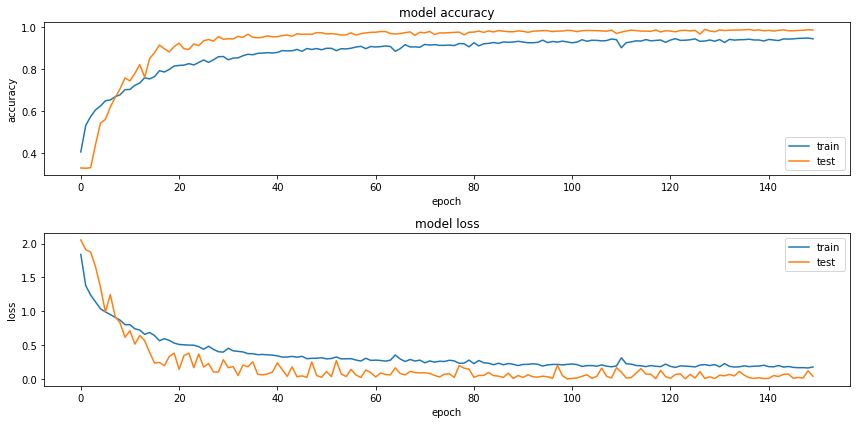

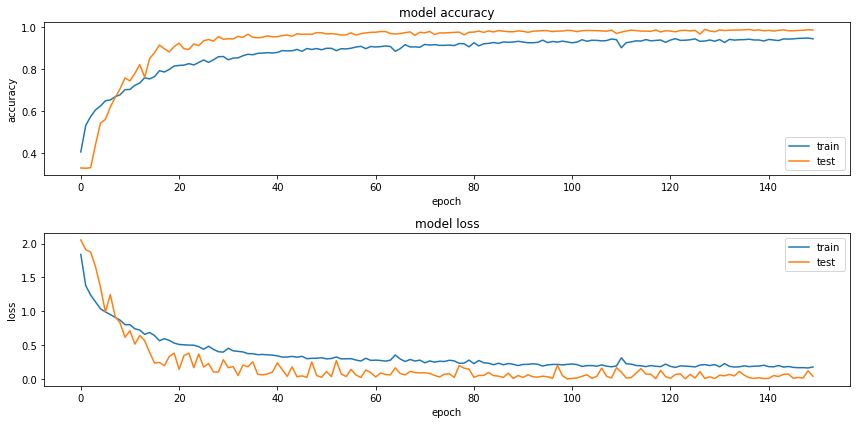

In [16]:
fig = plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
fig



####Testowanie modelu

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(picture_size, picture_size),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1,
        )

filenames = test_generator.filenames
classes_gen = test_generator.class_indices
classes_gen = test_generator.class_indices

loss_acc = model.evaluate(test_generator)
print(classes_gen)
print('loss= ', loss_acc[0])
print("acc= ", loss_acc[1])

Found 3407 images belonging to 10 classes.
3407/3407 [==============================] - 14s 4ms/step
{'cross': 0, 'limit40': 1, 'limit50': 2, 'limit60': 3, 'limit70': 4, 'limit80': 5, 'nosign': 6, 'othersign': 7, 'stop': 8, 'yield': 9}
loss=  0.0
acc=  0.9859113693237305


In [18]:
predict = model.predict_generator(test_generator,steps = len(filenames))
predict

array([[9.9902821e-01, 8.5122554e-07, 5.6747718e-05, ..., 2.1200697e-04,
        6.6411621e-06, 6.6536864e-05],
       [9.9989426e-01, 1.0317606e-07, 8.7314302e-06, ..., 5.2924548e-05,
        1.7611669e-07, 5.1399379e-06],
       [9.9995649e-01, 7.6028996e-09, 1.4745046e-06, ..., 2.8364564e-05,
        8.5597748e-08, 1.8515977e-06],
       ...,
       [2.5022340e-13, 1.4350559e-12, 3.4297089e-11, ..., 1.9655177e-09,
        6.9481248e-13, 1.0000000e+00],
       [2.5594302e-09, 2.8393550e-09, 4.4771191e-08, ..., 7.1507020e-07,
        1.7356912e-07, 9.9998903e-01],
       [1.8132710e-12, 4.8607934e-11, 7.2618472e-10, ..., 7.9468379e-09,
        1.0037010e-12, 1.0000000e+00]], dtype=float32)

In [19]:
from google.colab.patches import cv2_imshow

signs = test_generator.class_indices
prediction_list = []
memo_correct_percent = {}
for sign in signs:
  files = os.path.join(test_dir, sign)
  test_files = os.listdir(files)
  incorrect = 0
  for f in test_files:
    path_to_test = os.path.join(files, f)
    img = cv2.imread(path_to_test)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb,(picture_size,picture_size))
    img_resized_float = img_resized.astype("float32") / 255
    img_tensor = np.reshape(img_resized_float,[1,picture_size,picture_size,3])
    classes = (model.predict_classes(img_tensor)).tolist()
    for num, class_ in enumerate(signs):
      if classes[0] == num:
        classes = list(signs.keys())[list(signs.values()).index(num)]
    else:
      classes
    if classes != sign:
      # cv2_imshow(img)
      incorrect += 1 
  corrent_percent = round(100-(incorrect/len(test_files)*100))
  memo_correct_percent[sign] = corrent_percent
  prediction_note = f'{sign}: {incorrect} / {len(test_files)},  Poprawność: {corrent_percent}%'
  prediction_list.append(prediction_note)
  print(prediction_note)
mean_correct_percent = round(sum(memo_correct_percent.values()) / len(signs), 1)
print(f'Średnia poprawność predykcji: {mean_correct_percent}%')

cross: 0 / 409,  Poprawność: 100%
limit40: 6 / 98,  Poprawność: 94%
limit50: 3 / 312,  Poprawność: 99%
limit60: 8 / 191,  Poprawność: 96%
limit70: 2 / 211,  Poprawność: 99%
limit80: 4 / 206,  Poprawność: 98%
nosign: 14 / 1334,  Poprawność: 99%
othersign: 4 / 132,  Poprawność: 97%
stop: 5 / 236,  Poprawność: 98%
yield: 5 / 278,  Poprawność: 98%
Średnia poprawność predykcji: 97.8%


###Zapis danych modelu i wyników do pliku tekstowego

In [20]:
time_date = time.strftime("%d/%m/%Y - %H:%M:%S")
with open("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Log_data.txt", "a") as f:
  f.write(f"Model {time_date} \n")
  f.write(f"Funkcja aktywacji: {activation} \n")
  f.write(f"Ilość zdjęć treningowych: \n")
  for key, value in train_folders_length.items():
    f.write(f"\t{key}: {value}\n")
  f.write(f"Ilość zdjęć walidacyjnych: \n")
  for key, value in valid_folders_length.items():
    f.write(f"\t{key}: {value}\n")
  f.write(f"Parametry:\n \tEpochs: {epochs}\n \tMetrics: {metrics}\n \tLoss: {loss}\n \tClassification: {class_mode} \n")
  f.write(f"\tBatch size: {batch_size}\n")
  f.write(f"\tWielkość zdjęć: {picture_size}x{picture_size}px\n")
  f.write(f"\tIlość warstw modelu: {len(model.layers)}\n")
  f.write(f"\tDropout: 1 - {dropout_1}; 2 - {dropout_2}; 3 - {dropout_3}; 4 - {dropout_4}; 5 - {dropout_5}; 6 - {dropout_6}\n")
  f.write("\n")
  f.write("Wyniki: \n")
  f.write(f"\tSTRATA [loss]: {loss_acc[0]}\n")
  f.write(f"\tDOKŁADNOŚĆ [acc]: {loss_acc[1]}\n")
  f.write(f"\tIlość zdjęć testowych: {len(test_generator.filenames)}\n")
  for prediction in prediction_list:
    f.write(f"\t{prediction}\n")
  f.write(f"Średnia poprawność manualnej predykcji: {mean_correct_percent}% \n")
  f.write(f"Nazwa pliku: {model_name}")
  f.write("\n")
  f.write("-------------------------------------------------------------")
  f.write("\n\n")


###Zapis modelu (.json) i wag (.h5)

In [ ]:
model_name_json = 'model_10conv.json'
model_path = os.path.join("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data", model_name_json)
json_config = model.to_json()
with open(model_path, 'w') as json_file:
    json_file.write(json_config)

In [ ]:
model_name = 'model_signs_4_classes.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [ ]:
model_name = 'model_signs_4_multi_classes_softmax.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [ ]:
model_name = 'model_signs_4_multi_classes_sigmoid.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/Road_sign_rec/model_signs_9_classe_sigmoid_23052020.h5')

In [ ]:
figure = plt.figure()
files = os.path.join(test_dir, 'cross')
test_files = os.listdir(files)
path_to_test = os.path.join(files, test_files[100])
img = cv2.imread(path_to_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(picture_size,picture_size))
plt.imshow(img)
plt.show()


###Poprzednie wyniki do porównania

In [ ]:
Sigmoid 04062020
acc=  0.9838449358940125
cross: 2 / 409,  Correct: 100%
limit40: 4 / 98,  Correct: 96%
limit50: 3 / 312,  Correct: 99%
limit60: 7 / 191,  Correct: 96%
limit70: 3 / 211,  Correct: 99%
limit80: 4 / 206,  Correct: 98%
nosign: 12 / 813,  Correct: 99%
stop: 3 / 236,  Correct: 99%
Mean correct predict: 98.2%


Softmax 03062020 - zmian pic size + nowe zdjecia
acc=  0.9818255305290222
cross: 4 / 409,  Correct: 99%
limit40: 6 / 98,  Correct: 94%
limit50: 9 / 312,  Correct: 97%
limit60: 6 / 191,  Correct: 97%
limit70: 4 / 211,  Correct: 98%
limit80: 8 / 206,  Correct: 96%
nosign: 7 / 813,  Correct: 99%
stop: 4 / 236,  Correct: 98%
Mean correct predict: 97.2%

Softmax 03062020 - zmian pic size + zmian parametrow imagegeneratora
cross: 5 / 388,  Correct: 99%
limit40: 2 / 98,  Correct: 98%
limit50: 5 / 111,  Correct: 95%
limit60: 6 / 65,  Correct: 91%
limit70: 4 / 34,  Correct: 88%
limit80: 5 / 41,  Correct: 88%
nosign: 8 / 813,  Correct: 99%
stop: 4 / 167,  Correct: 98%
Mean correct predict: 94.5%

Softmax 03062020 - zmian pic size
acc=  0.9807804226875305
cross: 2 / 388,  Correct: 99%
limit40: 3 / 98,  Correct: 97%
limit50: 2 / 111,  Correct: 98%
limit60: 6 / 65,  Correct: 91%
limit70: 3 / 34,  Correct: 91%
limit80: 3 / 41,  Correct: 93%
nosign: 8 / 813,  Correct: 99%
stop: 3 / 167,  Correct: 98%
Mean correct predict: 95.8%

Softmax 03062020
acc=  0.9749563336372375
cross: 6 / 388,  Correct: 98%
limit40: 2 / 98,  Correct: 98%
limit50: 6 / 111,  Correct: 95%
limit60: 8 / 65,  Correct: 88%
limit70: 6 / 34,  Correct: 82%
limit80: 7 / 41,  Correct: 83%
nosign: 9 / 813,  Correct: 99%
stop: 3 / 167,  Correct: 98%
Mean correct predict: 92.6%

# Sigmoin 26052020:
cross: 4 / 388,  Correct: 99%
limit40: 3 / 98,  Correct: 97%
limit50: 6 / 111,  Correct: 95%
limit60: 6 / 65,  Correct: 91%
limit70: 4 / 34,  Correct: 88%
limit80: 6 / 41,  Correct: 85%
nosign: 5 / 813,  Correct: 99%
stop: 2 / 167,  Correct: 99%
Mean correct predict: 94.1%


##Detekcja wideo

###Pliki i ścieżki

In [ ]:
video_path_input_directory = '/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Input'
video_file_name = 'warsaw_drive_test.mp4'
video_path_file = os.path.join(video_path_input_directory, video_file_name)
video_path_output = '/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Output'
print(video_path_file)
from google.colab.patches import cv2_imshow

/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Input/warsaw_drive_test.mp4


In [ ]:
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  cap = cv2.VideoCapture(video_path_file)
  video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  cap_video_fps = int(cap.get(cv2.CAP_PROP_FPS))
  cap_video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  cap_video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  print("FPS", cap_video_fps)
  print("Length", video_length)
  writer = None
  (W, H) = (None, None)
  mean = np.array([100, 100, 100], dtype="float32")
  i = 0
  while True:
      i += 1
      print(f'{i} / {video_length}')
      (grabbed, frame) = cap.read()
      if not grabbed:
          break
      if W is None or H is None:
          (H, W) = frame.shape[:2]
      output = frame.copy()
      ss.setBaseImage(output)
      try:
        ss.switchToSelectiveSearchFast()
      except cv2.error:
        break
      ssresults = ss.process()
      for w, result in enumerate(ssresults):
          if w < 2000:
              x, y, w, h = result
              timage = output[y:y+h, x:x+w]
              resized = cv2.resize(timage, (100, 100), interpolation=cv2.INTER_AREA)
              resized = resized - mean
              img = np.expand_dims(resized, axis=0)
              out = model.predict(img/255.0, batch_size=10)
              if out[0][0] >= 0.99:
                  cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
      if writer is None:
          fourcc = cv2.VideoWriter_fourcc(*"MJPG")
          writer = cv2.VideoWriter('Output/out_video.mp4', 
                                   fourcc, 
                                   30,
                                   (W, H), 
                                   True,
                                   )
      writer.write(output)
      cv2_imshow(output)
  print("__END__")